# Pytorch Text - Generating Names With A Character-Level RNN
Notebook for following along with Pytorch Text text interpretation tutorial, looking at basic character level RNN to generate names [Pytorch](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)  website tutorial. <br><br>
The data can be downloaded [here](https://download.pytorch.org/tutorial/data.zip).

### Choices for data

<br>

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [1]:
#Import cell
import glob
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import numpy as np
import os
import pandas as pd
import pickle as pk
import random
import string
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import unicodedata

from __future__ import unicode_literals, print_function, division
from io import open

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(f"Device: {device}. Cuda available: {torch.cuda.is_available()}")
print("Imports complete")

Device: cuda. Cuda available: False
Imports complete


<br>

### Importing and preparing data sets
Importing and preparing the data for the models.

In [2]:
#Gather datasets and prepare them for consumption
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c)!= 'Mn' and c in all_letters)

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

print("Data sets functions defined.")

Data sets functions defined.


In [3]:
#Importing data sets
category_lines = {}
all_categories = []

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')


print("# categories: ", n_categories)
print(all_categories)
print(unicodeToAscii("O'Néàl"))
print("\nData sets successfully imported.")

# categories:  18
['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal

Data sets successfully imported.


In [4]:
#Loader definitions

print(f"Loaders defined, running on device: {device}")

Loaders defined, running on device: cuda


In [5]:
#Setting seed value
torch.manual_seed(1247)

<br>

### Class Definitions
<b>Classes:</b><br>
<ul>
    <li>TransformerModel - Language interpretting model.</li>
    <li>PositionalEncoding - Injects information about the relative or absolute position of tokens in the sequence.</li>
</ul>

In [6]:
#Class definition cell
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        return None
    
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
print("Classes defined.")

Classes defined.


<br>

### Calculation functions
<b>Functions:</b><br>
<ul>
    <li>randomChoice - Returns random item from a list</li>
    <li>randomTrainingPair - get a random category and a random line from it</li>
    <li>randomTrainingExample - Make category, input and target tnesors from a random category, line pair</li>
    <li>categoryTensor - One-hot vector for category</li>
    <li>inputTensor - One-hot matrix of first to last letters (excluding EOS) for input</li>
    <li>targetTensor - Longtensor of second letter to end (EOS) for target)</li>
    <li>sample - sample from a category and starting letter</li>
    <li>samples - get multiple samples from one category and multiple starting lines</li>
</ul>

In [7]:
#Calculation functions cell
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters-1) #EOS
    return torch.LongTensor(letter_indexes)

def sample(category, start_letter='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        output_name = start_letter
        
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
                
            input = inputTensor(letter)
            
        return output_name

def samples(category, start_letters='ABC'):
    for start_letter in start_letters: print(sample(category, start_letter))
    return None
    
print("Calculation functions defined.")

Calculation functions defined.


<br>

### Plotting functions
<b>Functions:</b>
<ul>
    <li></li>
</ul>

In [8]:
#Plotting functions Cell

print("Plotting functions defined.")

Plotting functions defined.


<br>

### Main code
#### Creating the network

In [9]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_letters)
print("Network created.")

Network created.


#### Training The Network

In [10]:
criterion = nn.NLLLoss()
learning_rate = 0.005

In [11]:
#Function definitions
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        
    return output, loss.item()/input_line_tensor.size(0)


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' %(m, s)

In [12]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 #reset every plot_every iters
start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    
    if iter%print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, 
                                     iter/n_iters*100, loss))
    if iter%plot_every == 0:
        all_losses.append(total_loss/plot_every)
        total_loss = 0

0m 21s (5000 5%) 2.7890
0m 43s (10000 10%) 2.2989
1m 5s (15000 15%) 1.7991
1m 26s (20000 20%) 2.4497
1m 51s (25000 25%) 1.6907
2m 12s (30000 30%) 2.6898
2m 33s (35000 35%) 3.0654
2m 57s (40000 40%) 1.7232
3m 18s (45000 45%) 2.9553
3m 38s (50000 50%) 3.3372
3m 59s (55000 55%) 1.5091
4m 20s (60000 60%) 2.5124
4m 41s (65000 65%) 2.4194
5m 5s (70000 70%) 2.5421
5m 28s (75000 75%) 2.2877
6m 5s (80000 80%) 1.6503
6m 24s (85000 85%) 1.8102
6m 44s (90000 90%) 1.7795
7m 6s (95000 95%) 2.4494
7m 28s (100000 100%) 3.0060


#### Plotting Results

Training Losses


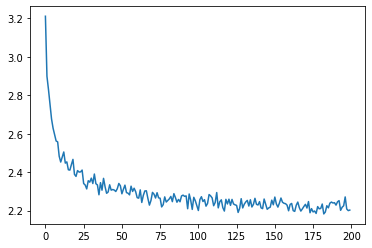

In [13]:
plt.figure()
plt.plot(all_losses)
print("Training Losses")

#### Sampling the Network

In [14]:
max_length = 20

samples('Russian', 'RUS')
print("-----------")
samples('German', 'GER')
print("-----------")
samples('Spanish', 'SPA')
print("-----------")
samples('Chinese', 'CHI')
print("-----------")

Romaker
Urtonok
Sharek
-----------
Grannor
Echer
Rom
-----------
Sarto
Parer
Aberrez
-----------
Chan
Han
Ino
-----------


<br>